In [5]:
%reload_ext autoreload
%autoreload 2

from helpers import *
from spice_net import *

import numpy as np
import networkx as nx
import tqdm
import random
import json
import matplotlib.pyplot as plt

import PySpice
PySpice.Spice.Simulation.CircuitSimulator.DEFAULT_SIMULATOR = "ngspice-shared" 
import PySpice.Spice.NgSpice.Server
PySpice.Spice.NgSpice.Server.SpiceServer.SPICE_COMMAND = 'ngspice'

In [6]:
# fix aliasing issues in later plots
plt.rcParams['figure.figsize'] = [10, 6]  # 10 inches wide, 6 inches tall

# Set global anti-aliasing for multiple plot types
plt.rcParams['lines.antialiased'] = True       # Lines
plt.rcParams['patch.antialiased'] = True       # Patches (bars, polygons, etc.)
plt.rcParams['text.antialiased'] = True        # Text
plt.rcParams['image.interpolation'] = 'antialiased'  # Interpolation for images


In [7]:
import PySpice.Spice.NgSpice.Shared

instance = PySpice.Spice.NgSpice.Shared.NgSpiceShared.new_instance()

Unsupported Ngspice version 43


In [8]:
R_LEARN = u_Ohm(100)
C_LEARN = u_uF(22)

In [9]:
VIN = u_V(1)
VCLAMP = u_V(0.2)

In [105]:
# handmake a twin edge voltage divider
cir = Circuit('twin_edge_divider')

cir.subcircuit(Teacher(c_learn=C_LEARN))
cir.subcircuit(TransistorEdgeTeacher())
cir.model('nmos', 'nmos', level=1)
cir.model('Ideal', 'nmos', level=1)
cir.model("MYSW", "SW", Ron=R_LEARN, Roff=1e12, Vt=0.5,)

cir.X("EC1", "transistor_edge_teacher", "C1", cir.gnd, "VGS1")
# cir.X("EC1", "transistor_edge", "C1", cir.gnd, vgs="{V(VGS1)}")
# cir.X("EC2", "transistor_edge", "C2", "C1", "{V(VGS2)}")
cir.X("EC2", "transistor_edge_teacher", "C2", "C1", "VGS2")
# cir.R(1, "C2", "C1", u_kOhm(10))
cir.X("EF1", "transistor_edge_teacher", "F1", cir.gnd, "VGS1")
# cir.X("EF1", "transistor_edge", "F1", cir.gnd, vgs="{V(VGS1)}")
# cir.X("EF2", "transistor_edge", "F2", "F1", "{V(VGS2)}")
cir.X("EF2", "transistor_edge_teacher", "F2", "F1", "VGS2")
# cir.R(2, "F2", "F1", u_kOhm(10))

cir.X("T1", "teacher", "F1", cir.gnd, "C1", cir.gnd, "VGS1", "CLK",)
cir.X("T2", "teacher", "F2", "F1", "C2", "C1", "VGS2", "CLK",)

# cir.PulseVoltageSource("VCLK", "CLK", cir.gnd, initial_value=0, pulsed_value=1, pulse_width=u_us(10), period=u_us(20))
cir.PulseVoltageSource("VCLK", "CLK", cir.gnd, initial_value=0, pulsed_value=1, pulse_width=u_ms(10), period=u_ms(20))

# constant inputs
cir.V("FI1", "F2", cir.gnd, VIN)
cir.V("CI1", "C2", cir.gnd, VIN)

# clamps
cir.V("CC1", "C1", cir.gnd, VCLAMP)

# experiment with random indexing
n = 5
cir.RandomVoltageSource("rand", "rand", 0, "uniform", u_ms(20), 0, 0.5, 0.5)
cir.B("idx", "idx", 0, voltage_expression=f"1 + FLOOR(V(rand)*{n})")


BehavioralSource Bidx

In [106]:
cir.Bidx.voltage_expression

'1 + FLOOR(V(rand)*5)'

In [107]:
print(cir)

.title twin_edge_divider
.subckt teacher D_FREE S_FREE D_CLAMPED S_CLAMPED VGS CLK
BUPDATE nudge 0 v=V(VGS)+((V(S_FREE)-V(D_FREE))**2-(V(S_CLAMPED)-V(D_CLAMPED))**2)
S1 nudge VGS CLK 0 MYSW on
C1 VGS 0 22uF
.ends teacher

.subckt transistor_edge_teacher t_D t_S VGS
B1 t_G t_S v=V(VGS)
R1 t_D t_S 1e+16
M1 t_D t_G t_S t_S Ideal
.ends transistor_edge_teacher
XEC1 C1 0 VGS1 transistor_edge_teacher
XEC2 C2 C1 VGS2 transistor_edge_teacher
XEF1 F1 0 VGS1 transistor_edge_teacher
XEF2 F2 F1 VGS2 transistor_edge_teacher
XT1 F1 0 C1 0 VGS1 CLK teacher
XT2 F2 F1 C2 C1 VGS2 CLK teacher
VVCLK CLK 0 DC 0V PULSE(0V 1V 0s 0s 0s 10ms 20ms)
VFI1 F2 0 1V
VCI1 C2 0 1V
VCC1 C1 0 0.2V
Vrand rand 0 TRRANDOM(1 20ms 0s 0.5 0.5)
Bidx idx 0 v=1 + FLOOR(V(rand)*5)
.model nmos nmos (level=1)
.model Ideal nmos (level=1)
.model MYSW SW (Roff=1000000000000.0 Ron=100Ohm Vt=0.5)



In [108]:
simulator = cir.simulator(temperature=25, nominal_temperature=25, simulator='ngspice-subprocess')

In [109]:
simulator.initial_condition(VGS1=1)
simulator.initial_condition(VGS2=1)

In [110]:
print(simulator)

.title twin_edge_divider
.subckt teacher D_FREE S_FREE D_CLAMPED S_CLAMPED VGS CLK
BUPDATE nudge 0 v=V(VGS)+((V(S_FREE)-V(D_FREE))**2-(V(S_CLAMPED)-V(D_CLAMPED))**2)
S1 nudge VGS CLK 0 MYSW on
C1 VGS 0 22uF
.ends teacher

.subckt transistor_edge_teacher t_D t_S VGS
B1 t_G t_S v=V(VGS)
R1 t_D t_S 1e+16
M1 t_D t_G t_S t_S Ideal
.ends transistor_edge_teacher
XEC1 C1 0 VGS1 transistor_edge_teacher
XEC2 C2 C1 VGS2 transistor_edge_teacher
XEF1 F1 0 VGS1 transistor_edge_teacher
XEF2 F2 F1 VGS2 transistor_edge_teacher
XT1 F1 0 C1 0 VGS1 CLK teacher
XT2 F2 F1 C2 C1 VGS2 CLK teacher
VVCLK CLK 0 DC 0V PULSE(0V 1V 0s 0s 0s 10ms 20ms)
VFI1 F2 0 1V
VCI1 C2 0 1V
VCC1 C1 0 0.2V
Vrand rand 0 TRRANDOM(1 20ms 0s 0.5 0.5)
Bidx idx 0 v=1 + FLOOR(V(rand)*5)
.model nmos nmos (level=1)
.model Ideal nmos (level=1)
.model MYSW SW (Roff=1000000000000.0 Ron=100Ohm Vt=0.5)
.options TEMP = 25C
.options TNOM = 25C
.options NOINIT
.options filetype = binary
.ic V(VGS1)=1 V(VGS2)=1
.end



In [45]:
res = simulator.transient(step_time=u_ms(1), end_time=0.5)

In [46]:
print(res.simulation)

.title twin_edge_divider
.subckt teacher D_FREE S_FREE D_CLAMPED S_CLAMPED VGS CLK
BUPDATE nudge 0 v=V(VGS)+((V(S_FREE)-V(D_FREE))**2-(V(S_CLAMPED)-V(D_CLAMPED))**2)
S1 nudge VGS CLK 0 MYSW on
C1 VGS 0 22uF
.ends teacher

.subckt transistor_edge_teacher t_D t_S VGS
B1 t_G t_S v=V(VGS)
R1 t_D t_S 1e+16
M1 t_D t_G t_S t_S Ideal
.ends transistor_edge_teacher
XEC1 C1 0 VGS1 transistor_edge_teacher
XEC2 C2 C1 VGS2 transistor_edge_teacher
XEF1 F1 0 VGS1 transistor_edge_teacher
XEF2 F2 F1 VGS2 transistor_edge_teacher
XT1 F1 0 C1 0 VGS1 CLK teacher
XT2 F2 F1 C2 C1 VGS2 CLK teacher
VVCLK CLK 0 DC 0V PULSE(0V 1V 0s 0s 0s 10ms 20ms)
VFI1 F2 0 1V
VCI1 C2 0 1V
VCC1 C1 0 0.2V
Vrand rand 0 TRRANDOM(1 20ms 0s 0.5 0.5)
Bidx idx 0 v=1 + FLOOR(V(rand)*5)
.model nmos nmos (level=1)
.model Ideal nmos (level=1)
.model MYSW SW (Roff=1000000000000.0 Ron=1000Ohm Vt=0.5)
.options TEMP = 25C
.options TNOM = 25C
.options NOINIT
.options filetype = binary
.ic V(VGS1)=1 V(VGS2)=1
.end



In [47]:
res.nodes

{'xec1.t_g': WaveForm xec1.t_g [1.        1.        1.        ... 1.1376816 1.1376816 1.1376816]@V,
 'VGS1': WaveForm VGS1 [1.        1.        1.        ... 1.1376816 1.1376816 1.1376816]@V,
 'C1': WaveForm C1 [0.2 0.2 0.2 ... 0.2 0.2 0.2]@V,
 'xec2.t_g': WaveForm xec2.t_g [1.2        1.2        1.2        ... 0.84426139 0.84426139 0.84426139]@V,
 'VGS2': WaveForm VGS2 [1.         1.         1.         ... 0.64426139 0.64426139 0.64426139]@V,
 'C2': WaveForm C2 [1. 1. 1. ... 1. 1. 1.]@V,
 'xef1.t_g': WaveForm xef1.t_g [1.        1.        1.        ... 1.1376816 1.1376816 1.1376816]@V,
 'F1': WaveForm F1 [0.5        0.5        0.5        ... 0.20000008 0.20000008 0.20000008]@V,
 'xef2.t_g': WaveForm xef2.t_g [1.5        1.5        1.5        ... 0.84426148 0.84426148 0.84426148]@V,
 'F2': WaveForm F2 [1. 1. 1. ... 1. 1. 1.]@V,
 'xt1.nudge': WaveForm xt1.nudge [1.21       1.21       1.21       ... 1.13768164 1.13768164 1.13768164]@V,
 'CLK': WaveForm CLK [0.   0.01 0.02 ... 0.   0.   0

KeyError: 'clk'

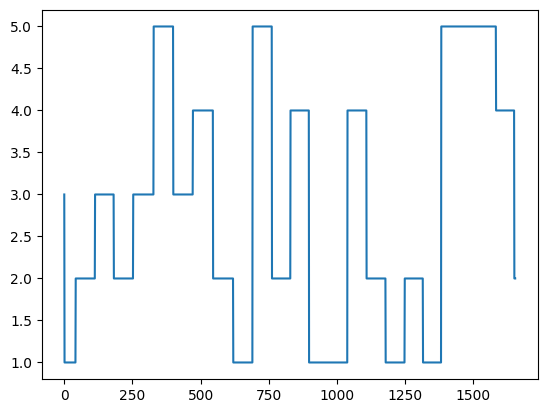

In [48]:
plt.plot(res.nodes['idx'])
plt.plot(res.nodes['clk'])

In [28]:
res.nodes.keys()

dict_keys(['xec1.t_g', 'VGS1', 'C1', 'xec2.t_g', 'VGS2', 'C2', 'xef1.t_g', 'F1', 'xef2.t_g', 'F2', 'xt1.nudge', 'CLK', 'xt2.nudge', 'rand', 'idx'])

In [49]:
MAX_STEP = 200
plt.plot(res.nodes['clk'][:MAX_STEP])
plt.plot(res.nodes['f1'][:MAX_STEP], label='f1')
plt.plot(res.nodes['c1'][:MAX_STEP], label='c1')
# plt.plot(res.nodes['vgs1'][:MAX_STEP], label='vgs1')
# plt.plot(res.nodes['xt1.nudge'][:MAX_STEP], label='nudge')
# plt.plot(res.nodes['f1']**2 - res.nodes['c1']**2, label='CL')
# plt.plot(res.nodes['vgs2'][:MAX_STEP], label='vgs2')
plt.legend()

KeyError: 'clk'

## Make larger twin networks

In [10]:
data = np.load("../data/xor_train_data_scale_1.0.npz")
inputs, outputs = data['inputs'], data['outputs'].astype(np.int64)

In [11]:
class TwinNetwork(AbstractNetwork):
    def __init__(self, name: str, con_graph: nx.Graph, node_cfg, solver, R_ON=u_Ohm(100), C_LEARN=u_uF(22), t_h=u_us(10), tau_0=u_ms(18)):

        # duplicate graph but preserve ground node
        cg_copy = con_graph.copy()
        cg_copy = nx.relabel_nodes(cg_copy, {x: x + con_graph.number_of_nodes() for x in cg_copy.nodes})
        cg_combined = nx.compose(con_graph, cg_copy)

        cg_combined = nx.contracted_nodes(cg_combined, 0, con_graph.number_of_nodes())

        # let the original graph be the clamped network and the copy be the free network
        # need to copy inputs to the free network, but outputs stay only in the clamped network
        free_net_offset = lambda x: x + con_graph.number_of_nodes() * (x != 0)

        inputs, outputs = node_cfg
        inputs_free = free_net_offset(inputs)
        inputs = np.concatenate([inputs, inputs_free])

        self.outputs_free = [[str(node) for node in of] for of in free_net_offset(outputs)] # for evaluation purposes only

        node_cfg = (inputs, outputs)

        # Set up nodes and underlying methods
        super().__init__(name, cg_combined, node_cfg, solver)
        

        # add edges and teachers
        self.model('nmos', 'nmos', level=1)
        self.model('Ideal', 'nmos', level=1)
        self.model("MYSW", "SW", Ron=R_LEARN, Roff=1e12, Vt=0.5,)

        self.free_edges = []
        self.clamped_edges = []
        self.teachers = []

        self.subcircuit(TransistorEdgeTeacher(r_shunt=1))
        self.subcircuit(Teacher(c_learn=C_LEARN))
        nodes_map = {n: i for i, n in enumerate(cg_combined.nodes())} # shared ground, all other nodes duplicated

        for n, (u, v, r) in enumerate(con_graph.edges(data="weight")):
            aux_node = "VGS" + str(n)
            self.__nodes__.append(aux_node)
            clamped_edge = self.X(f"C{n + 1}", TransistorEdgeTeacher.NAME, nodes_map[u], nodes_map[v], aux_node)
            free_edge = self.X(f"F{n + 1}", TransistorEdgeTeacher.NAME, free_net_offset(nodes_map[u]), free_net_offset(nodes_map[v]), aux_node)
            teacher = self.X(f"T{n+1}", Teacher.NAME, free_net_offset(nodes_map[u]), free_net_offset(nodes_map[v]), nodes_map[u], nodes_map[v], aux_node, "CLK")

            self.cached_simulator.initial_condition(**{aux_node: r})

            self.clamped_edges.append(clamped_edge)
            self.free_edges.append(free_edge)
            self.teachers.append(teacher)

        self.edges = self.clamped_edges + self.free_edges

        # add clock
        self.t_h = t_h
        self.tau_0 = tau_0
        self.PulseVoltageSource("VCLK", "CLK", 0, initial_value=0, pulsed_value=1, pulse_width=self.t_h, period=self.tau_0)

        # add support for random indexing
        self.RandomVoltageSource("rand", "rand", 0, "uniform", self.tau_0, 0, 0.5, 0.5)
        self.B("index", "index", 0)

    def _prepare_simulation(self, inputs, outputs, nudge_factor):
        inputs = np.hstack([inputs, inputs])

        super()._prepare_simulation(inputs, outputs)

        # make clamps use nudge factor
        for of, oc in zip(self.outputs_free, self.outputs):
            a, b = of
            if (nudge_factor > 0) and (nudge_factor < 1):
                oc.voltage_expression = f"{1-nudge_factor} * (V({a}) - V({b})) + {nudge_factor}*" + oc.voltage_expression
            elif nudge_factor == 0:
                oc.voltage_expression = f"V({a}) - V({b})"
            elif nudge_factor == 1:
                pass
            else:
                raise ValueError("Nudge factor must be between 0 and 1 (inclusive)")

        # experiment with random indexing
        self.Vindex.enabled = False
        self.Bindex.enabled = True
        self.Bindex.voltage_expression = f"1 + FLOOR(V(rand)*{self.n_examples})"


In [87]:
seed = 0
np.random.seed(seed)

grid_size = 20

grid_graph = nx.grid_graph([grid_size, grid_size], periodic=True)
# relabel nodes to be ints
grid_graph = nx.convert_node_labels_to_integers(grid_graph, first_label=0, ordering='sorted')

# grid_graph.add_node((-1, -1))

for e in grid_graph.edges:
    # grid_graph[e[0]][e[1]]['weight'] = 0.5                           # init to max value
    grid_graph[e[0]][e[1]]['weight'] = random.uniform(0.1, 0.9)       # random value

node_cfg = (np.array([[5, 16], [7, 16], [13, 16], [15, 16]]), np.array([[10, 0]]))

In [88]:
twin_net = TwinNetwork('twin_net', grid_graph, node_cfg, 'ngspice-shared', t_h=u_us(100), tau_0=u_us(200))
# twin_net = TwinNetwork('twin_net', grid_graph, node_cfg, 'ngspice-subprocess', t_h=u_us(100), tau_0=u_ms(20))

In [89]:
nudge_factor = 0.5
twin_net._prepare_simulation(inputs, outputs, nudge_factor)

In [90]:
twin_net.cached_simulator.options("acct")
twin_net.cached_simulator.options("CHGTOL=1e-16")

In [91]:
twin_net.cached_simulator.options("KLU")

In [92]:
n_iters = 10
u_s(n_iters * twin_net.tau_0)

PeriodValue(0.002 s)

In [93]:
res = twin_net.cached_simulator.transient(step_time=twin_net.t_h, end_time=n_iters * twin_net.tau_0,)

Using KLU as Direct Linear Solver


In [94]:
print(res.simulation)

.title twin_net
.subckt transistor_edge_teacher t_D t_S VGS
B1 t_G t_S v=V(VGS)
R1 t_D t_S 1
M1 t_D t_G t_S t_S Ideal
.ends transistor_edge_teacher

.subckt teacher D_FREE S_FREE D_CLAMPED S_CLAMPED VGS CLK
BUPDATE nudge 0 v=V(VGS)+((V(S_FREE)-V(D_FREE))**2-(V(S_CLAMPED)-V(D_CLAMPED))**2)
S1 nudge VGS CLK 0 MYSW on
C1 VGS 0 22uF
.ends teacher
B1 5 16 v={pwl(V(index), 1, 0.11, 2, 0.11, 3, 0.11, 4, 0.11)}
B2 7 16 v={pwl(V(index), 1, 0.33000000000000007, 2, 0.33000000000000007, 3, 0.33000000000000007, 4, 0.33000000000000007)}
B3 13 16 v={pwl(V(index), 1, 0.0, 2, 0.0, 3, 0.44999999999999996, 4, 0.44999999999999996)}
B4 15 16 v={pwl(V(index), 1, 0.0, 2, 0.44999999999999996, 3, 0.0, 4, 0.44999999999999996)}
B5 405 416 v={pwl(V(index), 1, 0.11, 2, 0.11, 3, 0.11, 4, 0.11)}
B6 407 416 v={pwl(V(index), 1, 0.33000000000000007, 2, 0.33000000000000007, 3, 0.33000000000000007, 4, 0.33000000000000007)}
B7 413 416 v={pwl(V(index), 1, 0.0, 2, 0.0, 3, 0.44999999999999996, 4, 0.44999999999999996)}
B8 415

In [95]:
res.nodes.keys()

dict_keys(['rand', 'xt800.nudge', 'xf800.t_g', 'vgs799', 'xc800.t_g', 'xt799.nudge', 'xf799.t_g', 'vgs798', 'xc799.t_g', 'xt798.nudge', 'xf798.t_g', 'vgs797', 'xc798.t_g', 'xt797.nudge', 'xf797.t_g', 'vgs796', 'xc797.t_g', 'xt796.nudge', 'xf796.t_g', 'vgs795', 'xc796.t_g', 'xt795.nudge', 'xf795.t_g', 'vgs794', 'xc795.t_g', 'xt794.nudge', 'xf794.t_g', 'vgs793', 'xc794.t_g', 'xt793.nudge', 'xf793.t_g', 'vgs792', 'xc793.t_g', 'xt792.nudge', 'xf792.t_g', 'vgs791', 'xc792.t_g', 'xt791.nudge', 'xf791.t_g', 'vgs790', 'xc791.t_g', 'xt790.nudge', 'xf790.t_g', 'vgs789', 'xc790.t_g', 'xt789.nudge', 'xf789.t_g', 'vgs788', 'xc789.t_g', 'xt788.nudge', 'xf788.t_g', 'vgs787', 'xc788.t_g', 'xt787.nudge', 'xf787.t_g', 'vgs786', 'xc787.t_g', 'xt786.nudge', 'xf786.t_g', 'vgs785', 'xc786.t_g', 'xt785.nudge', 'xf785.t_g', 'vgs784', 'xc785.t_g', 'xt784.nudge', 'xf784.t_g', 'vgs783', 'xc784.t_g', 'xt783.nudge', 'xf783.t_g', 'vgs782', 'xc783.t_g', 'xt782.nudge', 'xf782.t_g', 'vgs781', 'xc782.t_g', 'xt781.nudge

In [96]:
ZEROS = np.zeros_like(res.nodes['index'])
clamp_outputs = [res.nodes.get(s.node_names[0], ZEROS) - res.nodes.get(s.node_names[1], ZEROS) for s in twin_net.outputs]
free_outputs = [res.nodes.get(s[0], ZEROS) - res.nodes.get(s[1], ZEROS) for s in twin_net.outputs_free]

In [97]:
twin_net.outputs_free

[['410', '0']]

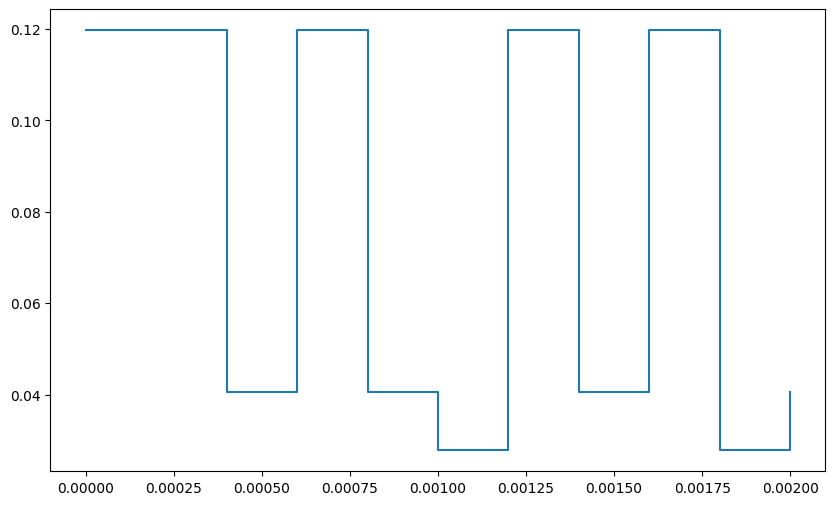

In [98]:
plt.plot(res.time, free_outputs[0])

In [112]:
n_iters = res.time.max().item() / twin_net.tau_0
n_iters

10.000000000000002

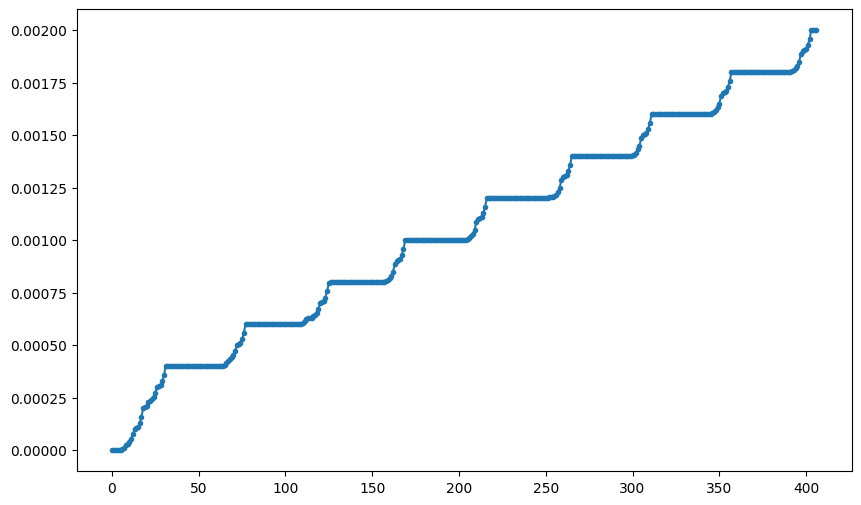

In [100]:
plt.plot(res.time[:-1],'.-')
# plt.ylim(0, .05)

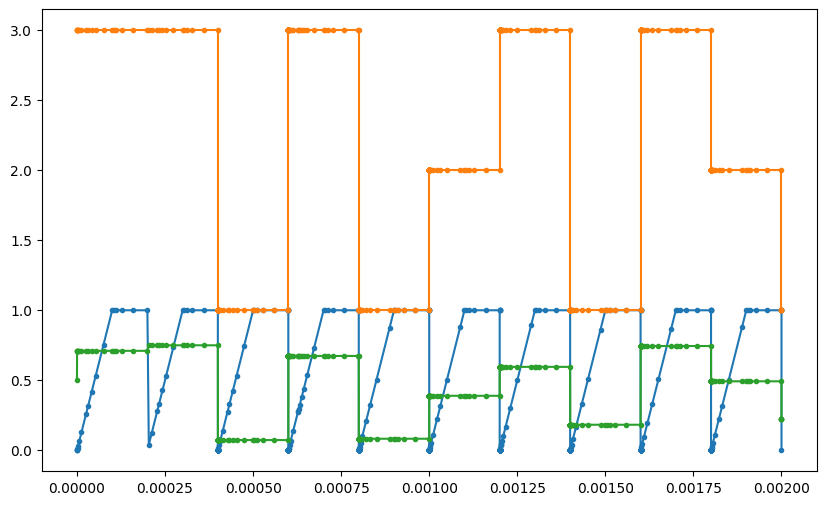

In [101]:
step = 500
plt.plot(res.time[:step], res.nodes['clk'][:step], '.-', antialiased=True)
plt.plot(res.time[:step], res.nodes['index'][:step], '.-', antialiased=True)
plt.plot(res.time[:step], res.nodes['rand'][:step], '.-', antialiased=True)
# plt.ylim(0, 1.1)

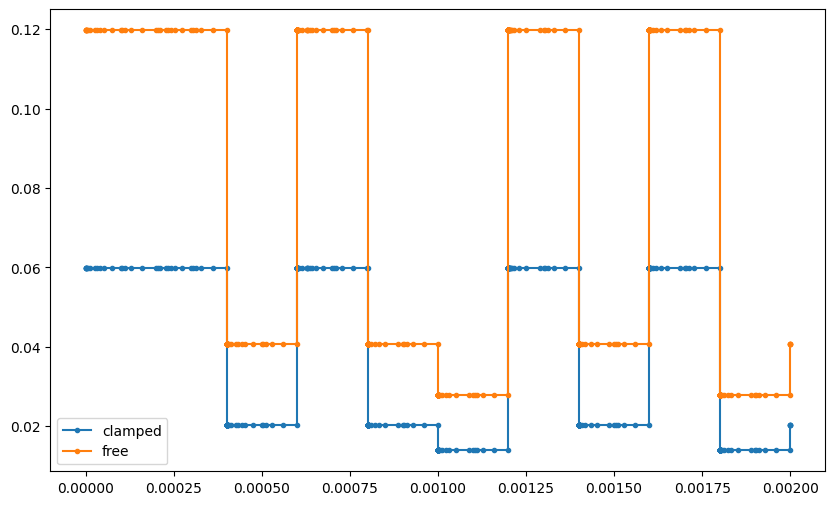

In [102]:
plt.plot(res.time[:step], clamp_outputs[0][:step], '.-', label='clamped')
plt.plot(res.time[:step], free_outputs[0][:step], '.-', label='free')
# plt.scatter(res.time[:step], clamp_outputs[0][:step], label='clamped')
# plt.(res.time[:step], free_outputs[0][:step], label='free')
# plt.ylim(-1, 1)
plt.legend()

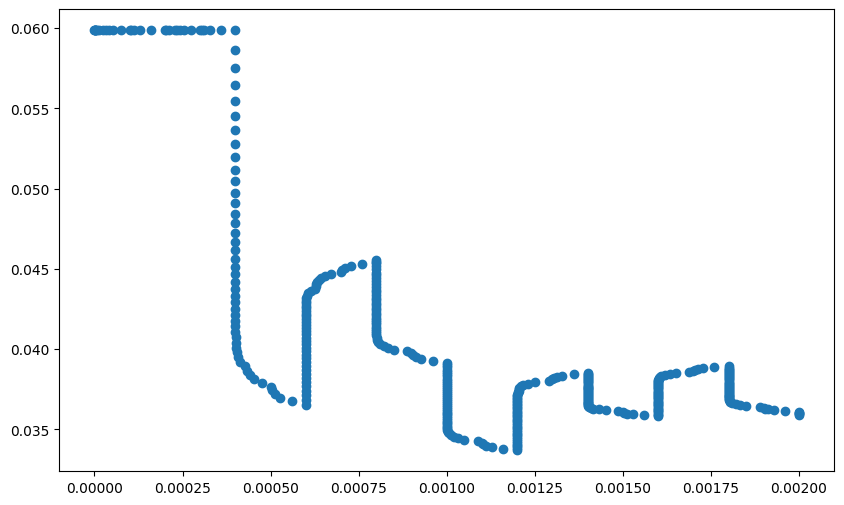

In [103]:
mae = np.cumsum(np.abs(clamp_outputs[0] - free_outputs[0])) / np.arange(1, len(clamp_outputs[0]) + 1)
plt.scatter(res.time, mae)

In [113]:
instance.ressource_usage()

{'Total elapsed time (seconds)': 26164.645,
 'elapsed time since last call (seconds)': 2284.472,
 'Total DRAM available': '16384.000 MB.',
 'DRAM currently available': ' 138.406 MB.',
 'Maximum ngspice program size': '0 bytes.',
 'Current ngspice program size': '  81.922 MB.',
 'Number of lines in the deck': 14431,
 'Netlist loading time': 0.005,
 'Subckt and Param expansion time': 0.035,
 'Netlist parsing time': 0.025,
 'Nominal temperature': 27,
 'Operating temperature': 27,
 'Total iterations': 2984,
 'Transient iterations': 2970,
 'Circuit Equations': 6414,
 'Circuit original non-zeroes': 28809,
 'Circuit fill-in non-zeroes': 118554,
 'Circuit total non-zeroes': 147363,
 'Transient timepoints': 422,
 'Accepted timepoints': 408,
 'Rejected timepoints': 14,
 'Total analysis time (seconds)': 14.649,
 'Matrix load time': 2.336,
 'Matrix synchronize time': 0,
 'Matrix reorder time': 0.022,
 'Matrix factor time': 10.677,
 'Matrix solve time': 0.433,
 'Transient analysis time': 14.06,
 'T

In [ ]:
instance.ressource_usage()

{'Total elapsed time (seconds)': 23880.173,
 'Total DRAM available': '16384.000 MB.',
 'DRAM currently available': '  68.359 MB.',
 'Maximum ngspice program size': '0 bytes.',
 'Current ngspice program size': ' 100.203 MB.',
 'Number of lines in the deck': 3631,
 'Netlist loading time': 0.002,
 'Subckt and Param expansion time': 0.01,
 'Netlist parsing time': 0.007,
 'Nominal temperature': 27,
 'Operating temperature': 27,
 'Total iterations': 1147,
 'Transient iterations': 1140,
 'Circuit Equations': 1614,
 'Circuit original non-zeroes': 7209,
 'Circuit fill-in non-zeroes': 16751,
 'Circuit total non-zeroes': 23960,
 'Transient timepoints': 544,
 'Accepted timepoints': 533,
 'Rejected timepoints': 11,
 'Total analysis time (seconds)': 0.535,
 'Matrix load time': 0.139,
 'Matrix synchronize time': 0,
 'Matrix reorder time': 0.003,
 'Matrix factor time': 0.293,
 'Matrix solve time': 0.034,
 'Transient analysis time': 0.502,
 'Transient load time': 0.123,
 'Transient sync time': 0,
 'Tra